# 1. Overview

This notebook focuses on building and fine-tuning machine learning models to classify the sentiment of tweets as positive or not. It explores several models, including Logistic Regression, Random Forest, Neural Networks, and XGBoost.

Key processes include:

- Splitting data into training and test sets.
- Applying weighted metrics (Precision, Recall, F1 Score) to handle class imbalance.
- Hyperparameter tuning using GridSearchCV for optimal performance, with a focus on maximizing precision to reduce false positives, as required by the business case.
- Comparison of model performance to select the best model.
- The final model is saved using pickle for future use.

The notebook concludes that XGBoost is the most suitable model due to its balanced performance and minimal overfitting.

# 2. Import Necessary Libraries

In [1]:
# pip install keras_tuner

In [62]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import xgboost as xgb
import pickle
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer, recall_score, f1_score
from tensorflow.keras.metrics import Precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, regularizers

# Delete the warnings
warnings.filterwarnings('ignore')

# 3. Define Global Variables

In [3]:
input_X_train_path = 'data/train_processed_prueba.csv'
input_X_test_path = 'data/test_processed_prueba.csv'

# 4. Functions

In [4]:
def plot_confusion_matrix_and_metrics(y_test, y_pred, title='Confusion Matrix'):
    """
    This function plots a confusion matrix and calculates the weighted F1 score, precision, and recall.

    Parameters:
    y_test (array-like): True labels
    y_pred (array-like): Predicted labels
    title (str): Title for the confusion matrix plot

    Returns:
    tuple: The weighted F1 score, precision score, and recall score
    """

    # Predefined labels list
    labels_list = ["Not Positive emotion", "Positive emotion"]

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Calculate percentages
    conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

    # Combine the count and the percentage into one annotation
    labels = [f"{count}\n{percent:.2f}%" for count, percent in zip(conf_matrix.flatten(), conf_matrix_percent.flatten())]
    labels = np.asarray(labels).reshape(2, 2)

    # Plot the confusion matrix without the color bar
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=labels, fmt="", cmap="Blues", cbar=False, 
                xticklabels=labels_list, 
                yticklabels=labels_list)

    plt.xlabel(r'$\bf{Predicted\ labels}$')
    plt.ylabel(r'$\bf{True\ labels}$')
    plt.title(title)
    plt.show()

    # Calculate weighted precision, recall, and F1 score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print metrics
    print(f"Weighted Precision: {precision:.2f}")
    print(f"Weighted Recall: {recall:.2f}")
    print(f"Weighted F1 Score: {f1:.2f}")

    return f1, precision, recall

In [5]:
def precision_results_table(y_train, y_test, 
                            y_pred_train_lr, y_pred_test_lr, 
                            y_pred_train_rf, y_pred_test_rf, y_pred_train_rf_2, y_pred_test_rf_2,
                            predicted_classes_train, predicted_classes_test, 
                            y_pred_train_xgb, y_pred_test_xgb, y_pred_train_xgb_2, y_pred_test_xgb_2):
    """
    Function to calculate and return a table with precision scores for train and test sets
    across different models.

    Parameters:
    y_train: Ground truth labels for the training set
    y_test: Ground truth labels for the test set
    y_pred_train_lr: Predictions for Logistic Regression (train set)
    y_pred_test_lr: Predictions for Logistic Regression (test set)
    y_pred_train_rf: Predictions for Random Forest (train set)
    y_pred_test_rf: Predictions for Random Forest (test set)
    y_pred_train_rf_2: Second set of predictions for Random Forest (train set)
    y_pred_test_rf_2: Second set of predictions for Random Forest (test set)
    predicted_classes_train: Predictions for Neural Networks (train set)
    predicted_classes_test: Predictions for Neural Networks (test set)
    y_pred_train_xgb: Predictions for XGBoost (train set)
    y_pred_test_xgb: Predictions for XGBoost (test set)
    y_pred_train_xgb_2: Second set of predictions for XGBoost (train set)
    y_pred_test_xgb_2: Second set of predictions for XGBoost (test set)

    Returns:
    A Pandas DataFrame containing precision scores for both train and test sets for each model.
    """
    
    # Calculate precision for Logistic Regression
    precision_train_lr = precision_score(y_train, y_pred_train_lr, average='weighted')
    precision_test_lr = precision_score(y_test, y_pred_test_lr, average='weighted')

    # Calculate precision for Random Forest (first set of predictions)
    precision_train_rf = precision_score(y_train, y_pred_train_rf, average='weighted')
    precision_test_rf = precision_score(y_test, y_pred_test_rf, average='weighted')

    # Calculate precision for Random Forest (second set of predictions)
    precision_train_rf_2 = precision_score(y_train, y_pred_train_rf_2, average='weighted')
    precision_test_rf_2 = precision_score(y_test, y_pred_test_rf_2, average='weighted')

    # Calculate precision for Neural Networks
    precision_train_nn = precision_score(y_train, predicted_classes_train, average='weighted')
    precision_test_nn = precision_score(y_test, predicted_classes_test, average='weighted')

    # Calculate precision for XGBoost (first set of predictions)
    precision_train_xgb = precision_score(y_train, y_pred_train_xgb, average='weighted')
    precision_test_xgb = precision_score(y_test, y_pred_test_xgb, average='weighted')

    # Calculate precision for XGBoost (second set of predictions)
    precision_train_xgb_2 = precision_score(y_train, y_pred_train_xgb_2, average='weighted')
    precision_test_xgb_2 = precision_score(y_test, y_pred_test_xgb_2, average='weighted')

    # Create a DataFrame to store the precision results
    results = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest 1', 'Random Forest 2', 'Neural Networks', 'XGBoost 1', 'XGBoost 2'],
        'Precision (Train)': [precision_train_lr, precision_train_rf, precision_train_rf_2, precision_train_nn, precision_train_xgb, precision_train_xgb_2],
        'Precision (Test)': [precision_test_lr, precision_test_rf, precision_test_rf_2, precision_test_nn, precision_test_xgb, precision_test_xgb_2]

    })
    
    # Creating another column to see the difference between the Train's and the Test's Precision
    results['Difference (Train-Test)'] = results['Precision (Train)'] - results['Precision (Test)']

    return results

# 5. Choosing the metric

Taking into consideration the Business case that was defined in the notebook 01_data_understanding, we are going to use the Precision score because we consider that the more false positives that we have, the more harmful it will be to the nature of our business because it will affect our analysis that we will do in the future to determine the positive features of the technological products. 

# 6. Code

We are going to open both csv files from the notebook 02_data_preprocessing

In [7]:
df_train = pd.read_csv(input_X_train_path)
df_test = pd.read_csv(input_X_test_path)

In [8]:
df_train.head()

,aapl,aaron,ab,abacus,abba,abc,aber,ability,able,abnormal,...,zms,zombie,zomg,zone,zoom,zynga,zzzs,emotion_type_encoded,product_mention_Both,product_mention_Google
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0


In [9]:
df_test.head()

,aapl,aaron,ab,abacus,abba,abc,aber,ability,able,abnormal,...,zms,zombie,zomg,zone,zoom,zynga,zzzs,emotion_type_encoded,product_mention_Both,product_mention_Google
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.379029,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0


Let's do the separation between X_train, y_train, X_test, y_test

In [10]:
# For train
X_train, y_train = df_train.drop('emotion_type_encoded', axis=1), df_train['emotion_type_encoded']

# For test
X_test, y_test = df_test.drop('emotion_type_encoded', axis=1), df_test['emotion_type_encoded']

We will now proceed to train different models

## 6.1 LR

In [11]:
# Initialize the Multinomial Logistic Regression model
lr = LogisticRegression(solver='liblinear', random_state=12)

# Fit the model on the training data
lr.fit(X_train, y_train)

# Make predictions on the test data
y_pred_proba_test_lr = lr.predict_proba(X_test)[:, 1]

# Let's apply a threshold to the probabilities of y_pred_proba_test_lr to determine y_pred_proba_test_lr
y_pred_test_lr = np.where(y_pred_proba_test_lr >= 0.34, 1, 0)

# Make predictions on the training data to check for overfitting
y_pred_proba_train_lr = lr.predict_proba(X_train)[:, 1]

# Let's apply a threshold to the probabilities of y_pred_proba_train_lr to determine y_pred_proba_train_lr
y_pred_train_lr = np.where(y_pred_proba_train_lr >= 0.34, 1, 0)

Let's look at the confusion matrix

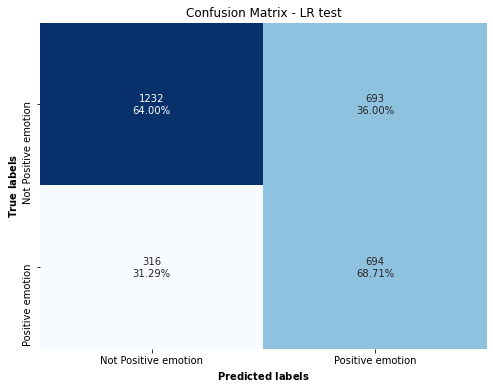

Weighted Precision: 0.69
Weighted Recall: 0.66
Weighted F1 Score: 0.66


In [12]:
plot_confusion_matrix_and_metrics(y_test, y_pred_test_lr, title='Confusion Matrix - LR test');

Let's look at the confusion matrix of the train dataset to check for overfitting

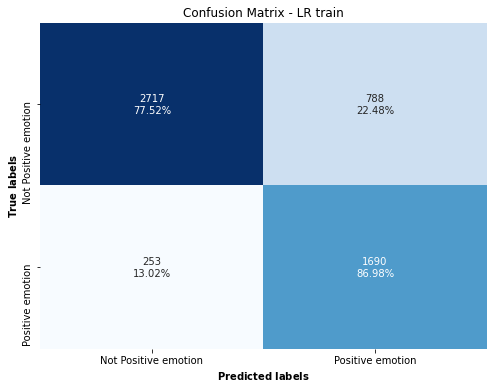

Weighted Precision: 0.83
Weighted Recall: 0.81
Weighted F1 Score: 0.81


In [13]:
plot_confusion_matrix_and_metrics(y_train, y_pred_train_lr, title='Confusion Matrix - LR train');

As can be seen. Here the overfitting is very low when we look at the different F1-Scores of the test and train dataset.

## 6.2 Random Forest

In [14]:
# Initializing the RandomForestClassifier
rf = RandomForestClassifier(random_state=12)

# Let's do a fit on X_train and y_train
rf.fit(X_train, y_train)

# Let's do the predict of X_test
y_pred_proba_test_rf = rf.predict_proba(X_test)[:,1]

# Let's apply a threshold to the probabilities of y_pred_proba_test_rf to determine y_pred_test_rf
y_pred_test_rf = np.where(y_pred_proba_test_rf >= 0.34, 1, 0)

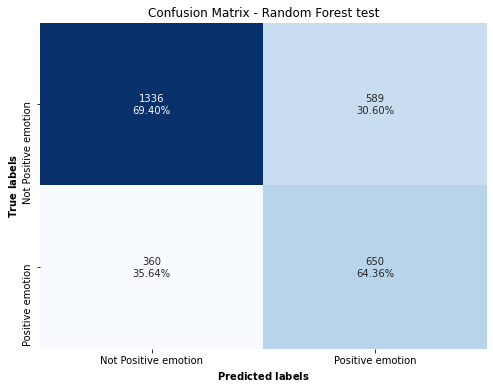

Weighted Precision: 0.70
Weighted Recall: 0.68
Weighted F1 Score: 0.68


In [15]:
plot_confusion_matrix_and_metrics(y_test, y_pred_test_rf, title='Confusion Matrix - Random Forest test');

We are going to check the level of overfitting in the Random Forest Model

In [16]:
# Let's do the predict of X_train
y_pred_proba_train_rf = rf.predict_proba(X_train)[:,1]

# Let's apply a threshold to the probabilities of y_pred_proba_train_rf to determine y_pred_test_rf
y_pred_train_rf = np.where(y_pred_proba_train_rf >= 0.34, 1, 0)

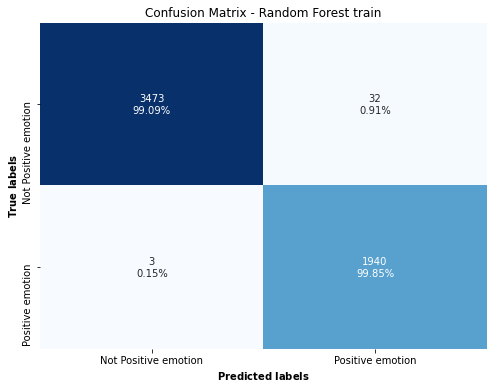

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1 Score: 0.99


In [17]:
plot_confusion_matrix_and_metrics(y_train, y_pred_train_rf, title='Confusion Matrix - Random Forest train');

As we can see, there is a very significant overfitting as the F1 score of the train dataset is 0.99 whereas the F1 score of the test dataset is 0.63

We are now going to do another Random Forest model to try to eliminate the overfitting.

In [18]:
# Initializing the RandomForestClassifier
rf_2 = RandomForestClassifier(n_estimators=60, max_depth=20, random_state=12)

# Let's do a fit on X_train and y_train
rf_2.fit(X_train, y_train)

# Let's do the predict of X_test
y_pred_proba_test_rf_2 = rf_2.predict_proba(X_test)[:,1]

# Let's apply a threshold to the probabilities of y_pred_proba_test_rf_2 to determine y_pred_test_rf_2
y_pred_test_rf_2 = np.where(y_pred_proba_test_rf_2 >= 0.34, 1, 0)

Let's take a look at the overfitting again

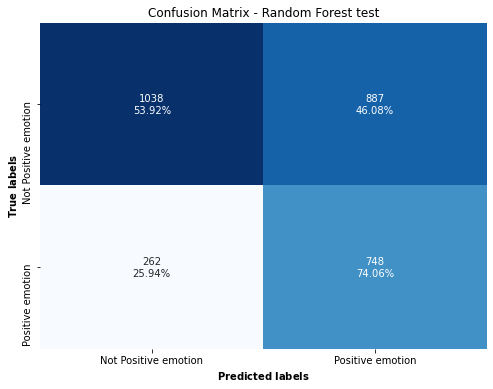

Weighted Precision: 0.68
Weighted Recall: 0.61
Weighted F1 Score: 0.62


In [19]:
plot_confusion_matrix_and_metrics(y_test, y_pred_test_rf_2, title='Confusion Matrix - Random Forest test');

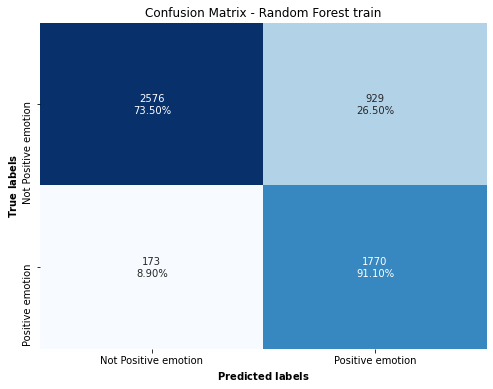

Weighted Precision: 0.84
Weighted Recall: 0.80
Weighted F1 Score: 0.80


In [20]:
# Let's do the predict of X_train
y_pred_train_rf_2 = rf_2.predict_proba(X_train)[:,1]

# Let's apply a threshold to the probabilities of y_pred_train_rf_2 to determine y_pred_train_rf_2
y_pred_train_rf_2 = np.where(y_pred_train_rf_2 >= 0.34, 1, 0)

plot_confusion_matrix_and_metrics(y_train, y_pred_train_rf_2, title='Confusion Matrix - Random Forest train');

We have been able to mitigate the overfitting, however the results are not satisfactory and so we decide to not use this model from now onwards.

## 6.3 Neural Networks

In [21]:
# Define the neural network model
model = Sequential()

# Adding the input layer and the first hidden layer with dropout
model.add(Dense(units=128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(rate=0.5))  # Dropout with 50% rate

# Adding the second hidden layer with dropout
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.5))  # Dropout with 50% rate

# Adding the third hidden layer with dropout
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.5))  # Dropout with 50% rate

# Adding the output layer
model.add(Dense(units=2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision()])

In [22]:
# Training the model

# Convert to NumPy arrays
X_train_np = X_train.to_numpy()  # Convert features to a NumPy array
y_train_np = to_categorical(y_train.to_numpy())  # Convert labels to a one-hot encoded NumPy array

# Doing the same conversion to the test data
X_test_np = X_test.to_numpy()
y_test_np = to_categorical(y_test.to_numpy())

# Doing the fit
model.fit(
    X_train_np,       # Input data (features)
    y_train_np,       # Target data (one-hot encoded labels)
    epochs=10,        # Number of times the model will see the entire dataset
    batch_size=64,    # Number of samples per gradient update
    validation_data=(X_test_np, y_test_np)  # Validation data (optional)
)

Epoch 1/10
86/86 [==============================] - 2s 14ms/step - loss: 0.6530 - precision: 0.6391 - val_loss: 0.6259 - val_precision: 0.6559
Epoch 2/10
86/86 [==============================] - 1s 7ms/step - loss: 0.6052 - precision: 0.6454 - val_loss: 0.5856 - val_precision: 0.7029
Epoch 3/10
86/86 [==============================] - 1s 6ms/step - loss: 0.5111 - precision: 0.7625 - val_loss: 0.5797 - val_precision: 0.6957
Epoch 4/10
86/86 [==============================] - 1s 7ms/step - loss: 0.3933 - precision: 0.8449 - val_loss: 0.6289 - val_precision: 0.6951
Epoch 5/10
86/86 [==============================] - 1s 6ms/step - loss: 0.3044 - precision: 0.8875 - val_loss: 0.7002 - val_precision: 0.7049
Epoch 6/10
86/86 [==============================] - 1s 7ms/step - loss: 0.2624 - precision: 0.9044 - val_loss: 0.7561 - val_precision: 0.7002
Epoch 7/10
86/86 [==============================] - 1s 6ms/step - loss: 0.2217 - precision: 0.9253 - val_loss: 0.8204 - val_precision: 0.7002
Epoch

In [23]:
# Make predictions
predictions_test = model.predict(X_test_np)

# Since the model outputs probabilities, we want to convert these to class labels
# Find the index of the maximum probability for each sample, which corresponds to the predicted class
predicted_classes_test = np.argmax(predictions_test, axis=1)

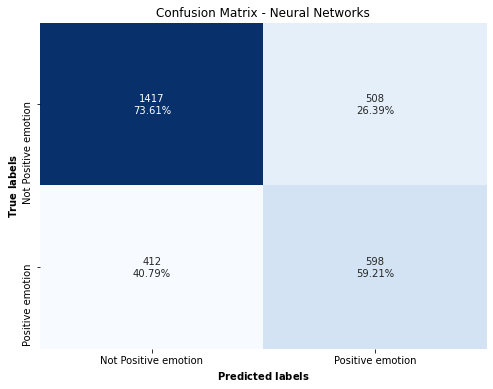

Weighted Precision: 0.69
Weighted Recall: 0.69
Weighted F1 Score: 0.69


In [24]:
plot_confusion_matrix_and_metrics(y_test, predicted_classes_test, title='Confusion Matrix - Neural Networks');

In [25]:
# Make predictions
predictions_train = model.predict(X_train_np)

# Since the model outputs probabilities, we want to convert these to class labels
# Find the index of the maximum probability for each sample, which corresponds to the predicted class
predicted_classes_train = np.argmax(predictions_train, axis=1)

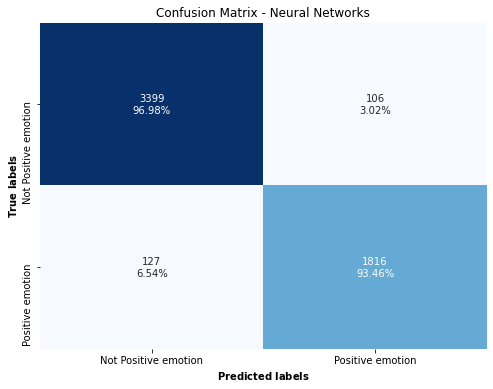

Weighted Precision: 0.96
Weighted Recall: 0.96
Weighted F1 Score: 0.96


In [26]:
plot_confusion_matrix_and_metrics(y_train, predicted_classes_train, title='Confusion Matrix - Neural Networks');

Based on the metrics that are printed by the neural network, we can see there is some overfitting but not too exagerated. As we iterate over the model, we will proceed to mitigate the overfitting.

## 6.4 Xgboost

In [27]:
# Initializing the XGBClassifier
xgb = XGBClassifier(random_state=12)

# Let's do a fit on X_train and y_train
xgb.fit(X_train, y_train)

# Let's do the predict of X_test
y_pred_proba_test_xgb = xgb.predict_proba(X_test)[:,1]

# Let's apply a threshold to the probabilities of y_pred_proba_test_xgb to determine y_pred_test_xgb
y_pred_test_xgb = np.where(y_pred_proba_test_xgb >= 0.34, 1, 0)

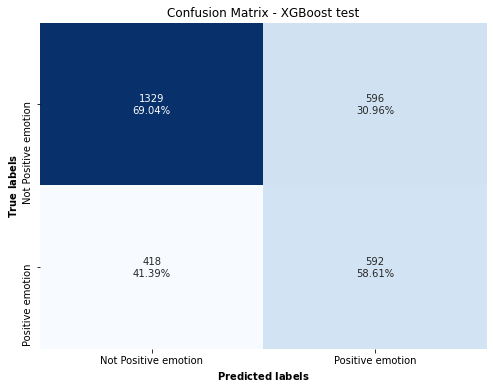

Weighted Precision: 0.67
Weighted Recall: 0.65
Weighted F1 Score: 0.66


In [28]:
plot_confusion_matrix_and_metrics(y_test, y_pred_test_xgb, title='Confusion Matrix - XGBoost test');

We are going to check the level of overfitting in the XGBoost

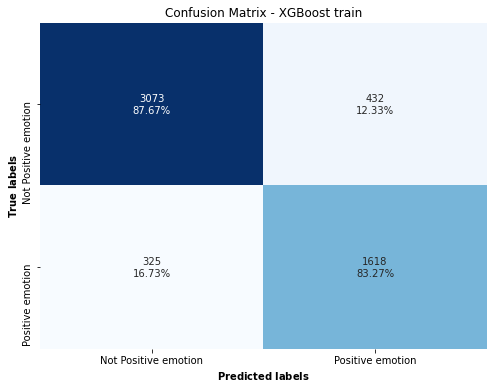

Weighted Precision: 0.86
Weighted Recall: 0.86
Weighted F1 Score: 0.86


In [29]:
# Let's do the predict of X_train
y_pred_proba_train_xgb = xgb.predict_proba(X_train)[:,1]

# Let's apply a threshold to the probabilities of y_pred_proba_train_xgb to determine y_pred_train_xgb
y_pred_train_xgb = np.where(y_pred_proba_train_xgb >= 0.34, 1, 0)

plot_confusion_matrix_and_metrics(y_train, y_pred_train_xgb, title='Confusion Matrix - XGBoost train');

As we can see the overfitting is high for XGBoost judging the F1-scores of the train and test datasets

We are now going to create another XGBoost model to try to reduce the overfitting

In [30]:
# Initializing the XGBClassifier
xgb_2 = XGBClassifier(random_state=12, max_depth=3, max_leaves=4)

# Let's do a fit on X_train and y_train
xgb_2.fit(X_train, y_train)

# Let's do the predict of X_test
y_pred_proba_test_xgb_2 = xgb_2.predict_proba(X_test)[:,1]

# Let's apply a threshold to the probabilities of y_pred_proba_test_xgb_2 to determine y_pred_test_xgb_2
y_pred_test_xgb_2 = np.where(y_pred_proba_test_xgb_2 >= 0.34, 1, 0)

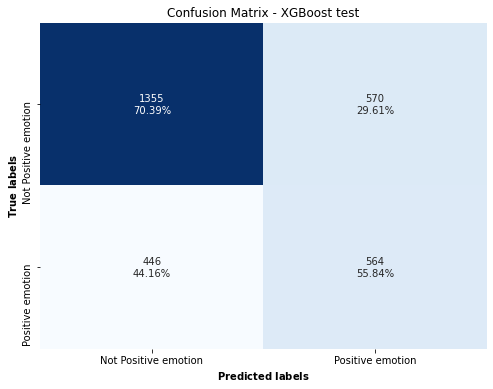

Weighted Precision: 0.66
Weighted Recall: 0.65
Weighted F1 Score: 0.66


In [31]:
plot_confusion_matrix_and_metrics(y_test, y_pred_test_xgb_2, title='Confusion Matrix - XGBoost test');

Let's look at the overfitting now

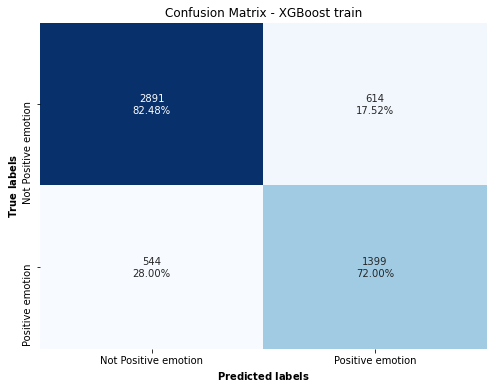

Weighted Precision: 0.79
Weighted Recall: 0.79
Weighted F1 Score: 0.79


In [32]:
# Let's do the predict of X_train
y_pred_proba_train_xgb_2 = xgb_2.predict_proba(X_train)[:,1]

# Let's apply a threshold to the probabilities of y_pred_proba_train_xgb_2 to determine y_pred_train_xgb_2
y_pred_train_xgb_2 = np.where(y_pred_proba_train_xgb_2 >= 0.34, 1, 0)

plot_confusion_matrix_and_metrics(y_train, y_pred_train_xgb_2, title='Confusion Matrix - XGBoost train');

## 6.5 Metric comparison

In [33]:
results_table = precision_results_table(y_train, y_test, 
                                        y_pred_train_lr, y_pred_test_lr,
                                        y_pred_train_rf, y_pred_test_rf, y_pred_train_rf_2, y_pred_test_rf_2,
                                        predicted_classes_train, predicted_classes_test,
                                        y_pred_train_xgb, y_pred_test_xgb, y_pred_train_xgb_2, y_pred_test_xgb_2)
results_table

,Model,Precision (Train),Precision (Test),Difference (Train-Test)
0,Logistic Regression,0.831783,0.694176,0.137608
1,Random Forest 1,0.993657,0.697191,0.296467
2,Random Forest 2,0.836755,0.681126,0.155628
3,Neural Networks,0.957158,0.694197,0.262961
4,XGBoost 1,0.863310,0.670429,0.192881
5,XGBoost 2,0.789329,0.664607,0.124722


It seems that the best models when considering the Train's and Test's Precision are XGBoost, Logistic Regression and the Random Forest

## 6.6 Fine-Tunning

Please note that we have commented the codes of the hyper-tunning for the different models given that their times of execution are too long. We have added the code of the hyper-tunning with the best parameters already for every model.

### 6.6.1 XGBoost

Given the nature of our business case, we decide that the metric we wish to optimize is the precision. The reason being is that our business intends to deduce from the tweets, that we've classified as having a positive feeling, the features of the technological products that bring happy emotions. 

The more false positives that we have, the more harmful it will be to the nature of our business because it will affect our analysis that we will do in the future to determine the positive features of the technological products. Thus, the metric we want to optimize is the precision to reduce our false positives. 

Nonetheless, we will also look at the fine-tunning focusing on optimizing recall and the f1-score

Let's do a fine-tunning focusing on optimizing precision

In [34]:
# # Define the parameter grid for XGBoost
# param_grid = {
#     'max_depth': [3, 7, 10],  # Maximum depth of a tree
#     'n_estimators': [100, 150],  # Number of trees
#     'colsample_bytree': [0.8, 1.0],  # Fraction of features used for each tree
#     'reg_lambda': [1, 2]  # L2 regularization term
# }

# # Create the XGBoost model
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# # Define the custom weighted precision scoring function
# precision_scorer = make_scorer(precision_score, average='weighted')

# # Initialize GridSearchCV
# grid_search_precision = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
#                            scoring=precision_scorer, cv=3, verbose=1, n_jobs=-1)

# # Fit the grid search to the training data
# grid_search_precision.fit(X_train, y_train)

# # Get the best model from the grid search
# best_model_xgb_precision = grid_search_precision.best_estimator_

# # Make predictions on the train set (probabilities)
# y_pred_proba_train_xgb_precision = best_model_xgb_precision.predict_proba(X_train)[:, 1]  # Get probabilities for class 1

# # Apply custom threshold to convert probabilities into binary predictions for training data
# y_pred_train_xgb_tuned_precision = np.where(y_pred_proba_train_xgb_precision >= 0.34, 1, 0)

# # Make predictions on the test set (probabilities)
# y_pred_proba_test_xgb_precision = best_model_xgb_precision.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# # Apply custom threshold to convert probabilities into binary predictions for test data
# y_pred_test_xgb_tuned_precision = np.where(y_pred_proba_test_xgb_precision >= 0.34, 1, 0)

# # Evaluate weighted precision on the test set using the custom threshold
# precision_test = precision_score(y_test, y_pred_test_xgb_tuned_precision, average='weighted')
# print(f"Weighted Precision on test set: {precision_test:.4f}")

# # Display the best parameters found by the grid search
# print(f"Best parameters found by GridSearchCV: {grid_search_precision.best_params_}")


After running the Gridsearch optimizing the precision metric, the best parameters that resulted where:

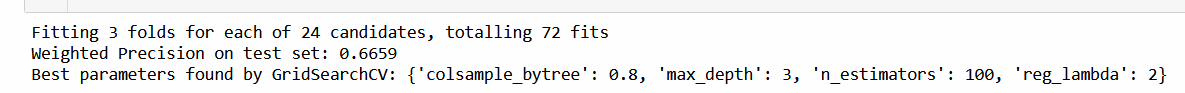

In [35]:
# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [3],  # Maximum depth of a tree
    'n_estimators': [100],  # Number of trees
    'colsample_bytree': [0.8],  # Fraction of features used for each tree
    'reg_lambda': [2] # L2 regularization term
}

# Create the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the custom weighted precision scoring function
precision_scorer = make_scorer(precision_score, average='weighted')

# Initialize GridSearchCV
grid_search_precision = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring=precision_scorer, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search_precision.fit(X_train, y_train)

# Get the best model from the grid search
best_model_xgb_precision = grid_search_precision.best_estimator_

# Make predictions on the train set (probabilities)
y_pred_proba_train_xgb_precision = best_model_xgb_precision.predict_proba(X_train)[:, 1]  # Get probabilities for class 1

# Apply custom threshold to convert probabilities into binary predictions for training data
y_pred_train_xgb_tuned_precision = np.where(y_pred_proba_train_xgb_precision >= 0.34, 1, 0)

# Make predictions on the test set (probabilities)
y_pred_proba_test_xgb_precision = best_model_xgb_precision.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Apply custom threshold to convert probabilities into binary predictions for test data
y_pred_test_xgb_tuned_precision = np.where(y_pred_proba_test_xgb_precision >= 0.34, 1, 0)

# Evaluate weighted precision on the test set using the custom threshold
precision_test = precision_score(y_test, y_pred_test_xgb_tuned_precision, average='weighted')
print(f"Weighted Precision on test set: {precision_test:.4f}")

# Display the best parameters found by the grid search
print(f"Best parameters found by GridSearchCV: {grid_search_precision.best_params_}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Weighted Precision on test set: 0.6659
Best parameters found by GridSearchCV: {'colsample_bytree': 0.8, 'max_depth': 3, 'n_estimators': 100, 'reg_lambda': 2}


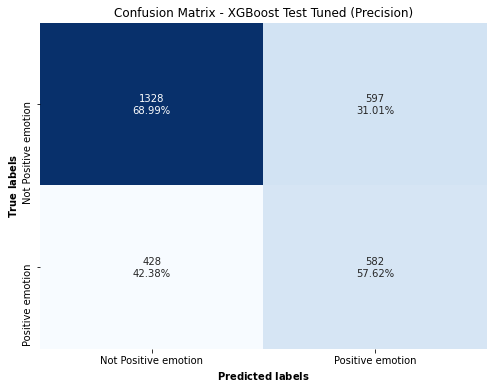

Weighted Precision: 0.67
Weighted Recall: 0.65
Weighted F1 Score: 0.66


In [36]:
plot_confusion_matrix_and_metrics(y_test, y_pred_test_xgb_tuned_precision, title='Confusion Matrix - XGBoost Test Tuned (Precision)');

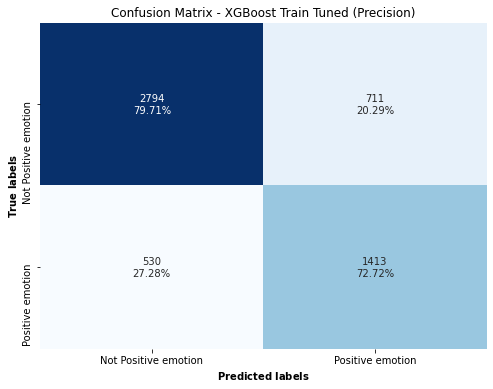

Weighted Precision: 0.78
Weighted Recall: 0.77
Weighted F1 Score: 0.77


In [37]:
plot_confusion_matrix_and_metrics(y_train, y_pred_train_xgb_tuned_precision, title='Confusion Matrix - XGBoost Train Tuned (Precision)');

We are going to look out for different metric scores to see what the metrics turn out being:

F1-Score

In [38]:
# # Define the parameter grid for XGBoost
# param_grid = {
#     'max_depth': [3, 7, 10],  # Maximum depth of a tree
#     'n_estimators': [100, 150],  # Number of trees
#     'colsample_bytree': [0.8, 1.0],  # Fraction of features used for each tree
#     'reg_lambda': [1, 2]  # L2 regularization term
# }

# # Create the XGBoost model
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# # Define the custom weighted F1 scoring function
# f1_scorer = make_scorer(f1_score, average='weighted')

# # Initialize GridSearchCV
# grid_search_f1 = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
#                            scoring=f1_scorer, cv=3, verbose=1, n_jobs=-1)

# # Fit the grid search to the training data
# grid_search_f1.fit(X_train, y_train)

# # Get the best model from the grid search
# best_model_xgb_f1 = grid_search_f1.best_estimator_

# # Make predictions on the train set (probabilities)
# y_pred_proba_train_xgb_f1 = best_model_xgb_f1.predict_proba(X_train)[:, 1]  # Get probabilities for class 1

# # Apply custom threshold to convert probabilities into binary predictions for training data
# y_pred_train_xgb_tuned_f1 = np.where(y_pred_proba_train_xgb_f1 >= 0.34, 1, 0)

# # Evaluate weighted F1-score on the training set using the custom threshold
# f1_train = f1_score(y_train, y_pred_train_xgb_tuned_f1, average='weighted')
# print(f"Weighted F1-score on training set: {f1_train:.4f}")

# # Make predictions on the test set (probabilities)
# y_pred_proba_test_xgb_f1 = best_model_xgb_f1.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# # Apply custom threshold to convert probabilities into binary predictions for test data
# y_pred_test_xgb_tuned_f1 = np.where(y_pred_proba_test_xgb_f1 >= 0.34, 1, 0)

# # Evaluate weighted F1-score on the test set using the custom threshold
# f1_test = f1_score(y_test, y_pred_test_xgb_tuned_f1, average='weighted')
# print(f"Weighted F1-score on test set: {f1_test:.4f}")

# # Display the best parameters found by the grid search
# print(f"Best parameters found by GridSearchCV: {grid_search_f1.best_params_}")


After running the Gridsearch optimizing the f1-score metric, the best parameters that resulted where:

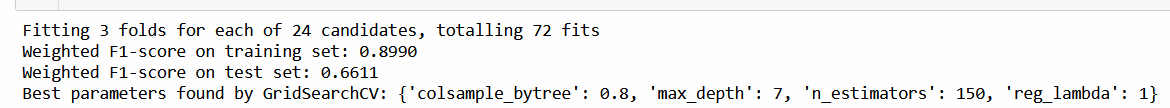

In [39]:
# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [7],  # Maximum depth of a tree
    'n_estimators': [150],  # Number of trees
    'colsample_bytree': [0.8],  # Fraction of features used for each tree
    'reg_lambda': [1]  # L2 regularization term
}

# Create the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the custom weighted F1 scoring function
f1_scorer = make_scorer(f1_score, average='weighted')

# Initialize GridSearchCV
grid_search_f1 = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring=f1_scorer, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search_f1.fit(X_train, y_train)

# Get the best model from the grid search
best_model_xgb_f1 = grid_search_f1.best_estimator_

# Make predictions on the train set (probabilities)
y_pred_proba_train_xgb_f1 = best_model_xgb_f1.predict_proba(X_train)[:, 1]  # Get probabilities for class 1

# Apply custom threshold to convert probabilities into binary predictions for training data
y_pred_train_xgb_tuned_f1 = np.where(y_pred_proba_train_xgb_f1 >= 0.34, 1, 0)

# Evaluate weighted F1-score on the training set using the custom threshold
f1_train = f1_score(y_train, y_pred_train_xgb_tuned_f1, average='weighted')
print(f"Weighted F1-score on training set: {f1_train:.4f}")

# Make predictions on the test set (probabilities)
y_pred_proba_test_xgb_f1 = best_model_xgb_f1.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Apply custom threshold to convert probabilities into binary predictions for test data
y_pred_test_xgb_tuned_f1 = np.where(y_pred_proba_test_xgb_f1 >= 0.34, 1, 0)

# Evaluate weighted F1-score on the test set using the custom threshold
f1_test = f1_score(y_test, y_pred_test_xgb_tuned_f1, average='weighted')
print(f"Weighted F1-score on test set: {f1_test:.4f}")

# Display the best parameters found by the grid search
print(f"Best parameters found by GridSearchCV: {grid_search_f1.best_params_}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Weighted F1-score on training set: 0.8990
Weighted F1-score on test set: 0.6611
Best parameters found by GridSearchCV: {'colsample_bytree': 0.8, 'max_depth': 7, 'n_estimators': 150, 'reg_lambda': 1}


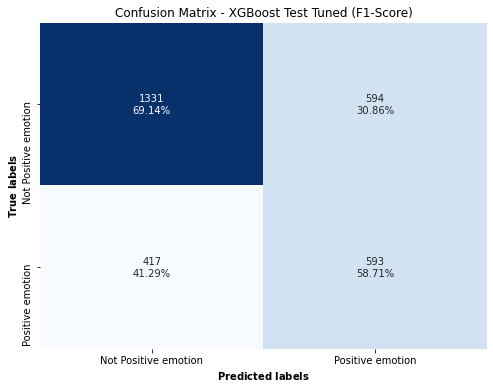

Weighted Precision: 0.67
Weighted Recall: 0.66
Weighted F1 Score: 0.66


In [40]:
plot_confusion_matrix_and_metrics(y_test, y_pred_test_xgb_tuned_f1, title='Confusion Matrix - XGBoost Test Tuned (F1-Score)');

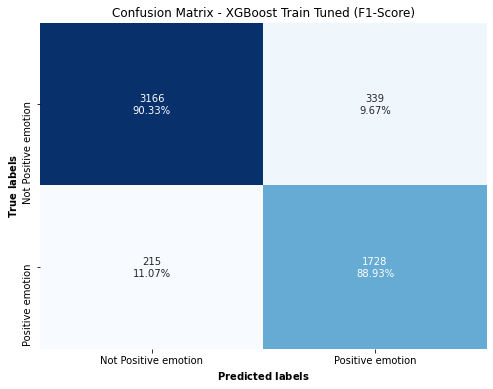

Weighted Precision: 0.90
Weighted Recall: 0.90
Weighted F1 Score: 0.90


In [41]:
plot_confusion_matrix_and_metrics(y_train, y_pred_train_xgb_tuned_f1, title='Confusion Matrix - XGBoost Train Tuned (F1-Score)');

Recall

In [42]:
# # Define the parameter grid for XGBoost
# param_grid = {
#     'max_depth': [3, 7, 10],  # Maximum depth of a tree
#     'n_estimators': [100, 150],  # Number of trees
#     'colsample_bytree': [0.8, 1.0],  # Fraction of features used for each tree
#     'reg_lambda': [1, 2]  # L2 regularization term
# }

# # Create the XGBoost model
# xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# # Define the custom weighted recall scoring function
# recall_scorer = make_scorer(recall_score, average='weighted')

# # Initialize GridSearchCV
# grid_search_recall = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
#                            scoring=recall_scorer, cv=3, verbose=1, n_jobs=-1)

# # Fit the grid search to the training data
# grid_search_recall.fit(X_train, y_train)

# # Get the best model from the grid search
# best_model_xgb_recall = grid_search_recall.best_estimator_

# # Make predictions on the train set (probabilities)
# y_pred_proba_train_xgb_recall = best_model_xgb_recall.predict_proba(X_train)[:, 1]  # Get probabilities for class 1

# # Apply custom threshold to convert probabilities into binary predictions for training data
# y_pred_train_xgb_tuned_recall = np.where(y_pred_proba_train_xgb_recall >= 0.34, 1, 0)

# # Evaluate weighted recall on the training set using the custom threshold
# recall_train = recall_score(y_train, y_pred_train_xgb_tuned_recall, average='weighted')
# print(f"Weighted Recall on training set: {recall_train:.4f}")

# # Make predictions on the test set (probabilities)
# y_pred_proba_test_xgb_recall = best_model_xgb_recall.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# # Apply custom threshold to convert probabilities into binary predictions for test data
# y_pred_test_xgb_tuned_recall = np.where(y_pred_proba_test_xgb_recall >= 0.34, 1, 0)

# # Evaluate weighted recall on the test set using the custom threshold
# recall_test = recall_score(y_test, y_pred_test_xgb_tuned_recall, average='weighted')
# print(f"Weighted Recall on test set: {recall_test:.4f}")

# # Display the best parameters found by the grid search
# print(f"Best parameters found by GridSearchCV: {grid_search_recall.best_params_}")


After running the Gridsearch optimizing the recall metric, the best parameters that resulted where:

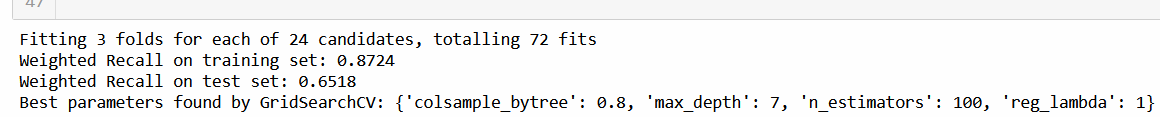


In [43]:
# Define the parameter grid for XGBoost
param_grid = {
    'max_depth': [7],  # Maximum depth of a tree
    'n_estimators': [100],  # Number of trees
    'colsample_bytree': [0.8],  # Fraction of features used for each tree
    'reg_lambda': [1]  # L2 regularization term
}

# Create the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define the custom weighted recall scoring function
recall_scorer = make_scorer(recall_score, average='weighted')

# Initialize GridSearchCV
grid_search_recall = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring=recall_scorer, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search_recall.fit(X_train, y_train)

# Get the best model from the grid search
best_model_xgb_recall = grid_search_recall.best_estimator_

# Make predictions on the train set (probabilities)
y_pred_proba_train_xgb_recall = best_model_xgb_recall.predict_proba(X_train)[:, 1]  # Get probabilities for class 1

# Apply custom threshold to convert probabilities into binary predictions for training data
y_pred_train_xgb_tuned_recall = np.where(y_pred_proba_train_xgb_recall >= 0.34, 1, 0)

# Evaluate weighted recall on the training set using the custom threshold
recall_train = recall_score(y_train, y_pred_train_xgb_tuned_recall, average='weighted')
print(f"Weighted Recall on training set: {recall_train:.4f}")

# Make predictions on the test set (probabilities)
y_pred_proba_test_xgb_recall = best_model_xgb_recall.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Apply custom threshold to convert probabilities into binary predictions for test data
y_pred_test_xgb_tuned_recall = np.where(y_pred_proba_test_xgb_recall >= 0.34, 1, 0)

# Evaluate weighted recall on the test set using the custom threshold
recall_test = recall_score(y_test, y_pred_test_xgb_tuned_recall, average='weighted')
print(f"Weighted Recall on test set: {recall_test:.4f}")

# Display the best parameters found by the grid search
print(f"Best parameters found by GridSearchCV: {grid_search_recall.best_params_}")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Weighted Recall on training set: 0.8724
Weighted Recall on test set: 0.6518
Best parameters found by GridSearchCV: {'colsample_bytree': 0.8, 'max_depth': 7, 'n_estimators': 100, 'reg_lambda': 1}


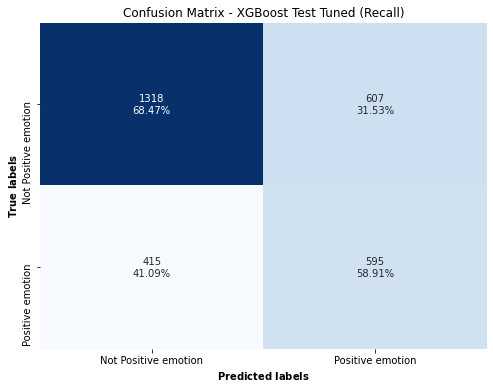

Weighted Precision: 0.67
Weighted Recall: 0.65
Weighted F1 Score: 0.66


In [44]:
plot_confusion_matrix_and_metrics(y_test, y_pred_test_xgb_tuned_recall, title='Confusion Matrix - XGBoost Test Tuned (Recall)');

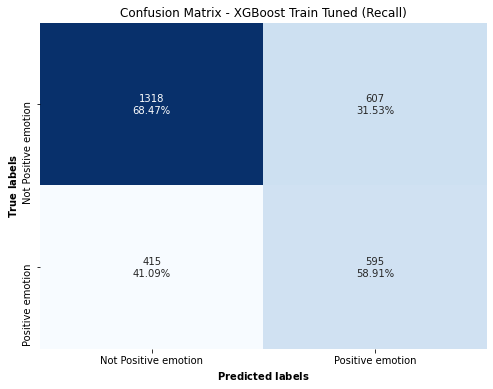

Weighted Precision: 0.67
Weighted Recall: 0.65
Weighted F1 Score: 0.66


In [45]:
plot_confusion_matrix_and_metrics(y_test, y_pred_test_xgb_tuned_recall, title='Confusion Matrix - XGBoost Train Tuned (Recall)');

### 6.6.2 Random Forest

In [46]:
# # Define the parameter grid for Random Forest
# param_grid_rf = {
#     'n_estimators': [100, 150],  # Number of trees
#     'max_depth': [5, 10, 20],  # Maximum depth of the tree
#     'min_samples_leaf': [4, 6],  # Minimum number of samples required to be at a leaf node
# }

# # Create the Random Forest model
# rf_model = RandomForestClassifier()

# # Define the custom precision scoring function
# precision_scorer = make_scorer(precision_score, average='weighted')

# # Initialize GridSearchCV
# grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
#                               scoring=precision_scorer, cv=3, verbose=1, n_jobs=-1)

# # Fit the grid search to the training data
# grid_search_rf.fit(X_train, y_train)

# # Get the best model from the grid search
# best_model_rf = grid_search_rf.best_estimator_

# # Make predictions on the train set
# y_pred_proba_train_rf = best_model_rf.predict_proba(X_train)[:, 1]  # Get probabilities for class 1

# # Apply custom threshold to convert probabilities into binary predictions
# y_pred_train_rf_tuned = np.where(y_pred_proba_train_rf >= 0.34, 1, 0)

# # Make predictions on the test set
# y_pred_proba_test_rf = best_model_rf.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# # Apply custom threshold to convert probabilities into binary predictions
# y_pred_test_rf_tuned = np.where(y_pred_proba_test_rf >= 0.34, 1, 0)

# # Evaluate precision on the test set using the custom threshold
# precision_test_rf = precision_score(y_test, y_pred_test_rf_tuned, average='weighted')
# print(f"Precision on test set (Random Forest): {precision_test_rf:.4f}")

# # Display the best parameters found by the grid search
# print(f"Best parameters found by GridSearchCV (Random Forest): {grid_search_rf.best_params_}")

After running the Gridsearch optimizing the precision metric, the best parameters that resulted where:

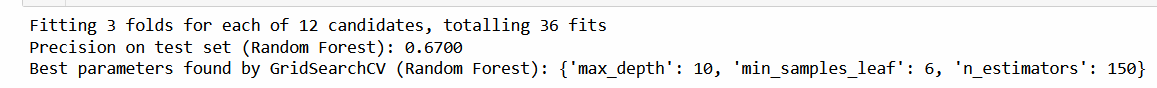

In [47]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [150],  # Number of trees
    'max_depth': [10],  # Maximum depth of the tree
    'min_samples_leaf': [6],  # Minimum number of samples required to be at a leaf node
}

# Create the Random Forest model
rf_model = RandomForestClassifier()

# Define the custom precision scoring function
precision_scorer = make_scorer(precision_score, average='weighted')

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, 
                              scoring=precision_scorer, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search_rf.fit(X_train, y_train)

# Get the best model from the grid search
best_model_rf = grid_search_rf.best_estimator_

# Make predictions on the train set
y_pred_proba_train_rf = best_model_rf.predict_proba(X_train)[:, 1]  # Get probabilities for class 1

# Apply custom threshold to convert probabilities into binary predictions
y_pred_train_rf_tuned = np.where(y_pred_proba_train_rf >= 0.34, 1, 0)

# Make predictions on the test set
y_pred_proba_test_rf = best_model_rf.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Apply custom threshold to convert probabilities into binary predictions
y_pred_test_rf_tuned = np.where(y_pred_proba_test_rf >= 0.34, 1, 0)

# Evaluate precision on the test set using the custom threshold
precision_test_rf = precision_score(y_test, y_pred_test_rf_tuned, average='weighted')
print(f"Precision on test set (Random Forest): {precision_test_rf:.4f}")

# Display the best parameters found by the grid search
print(f"Best parameters found by GridSearchCV (Random Forest): {grid_search_rf.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Precision on test set (Random Forest): 0.6728
Best parameters found by GridSearchCV (Random Forest): {'max_depth': 10, 'min_samples_leaf': 6, 'n_estimators': 150}


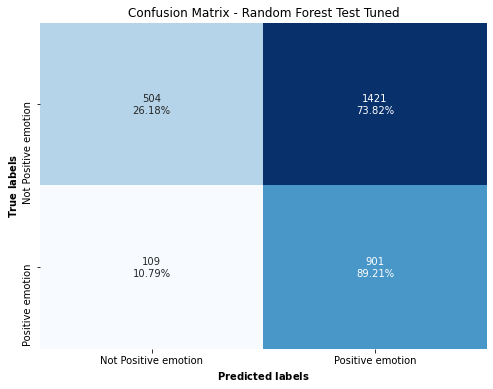

Weighted Precision: 0.67
Weighted Recall: 0.48
Weighted F1 Score: 0.45


In [48]:
plot_confusion_matrix_and_metrics(y_test, y_pred_test_rf_tuned, title='Confusion Matrix - Random Forest Test Tuned');

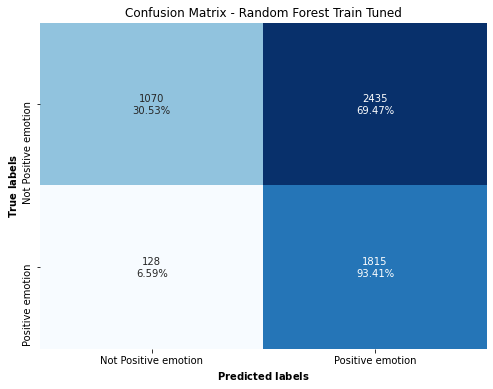

Weighted Precision: 0.73
Weighted Recall: 0.53
Weighted F1 Score: 0.50


In [49]:
plot_confusion_matrix_and_metrics(y_train, y_pred_train_rf_tuned, title='Confusion Matrix - Random Forest Train Tuned');

### 6.6.3 Logistic Regression

In [50]:
# # Define the parameter grid for Logistic Regression
# param_grid = {
#     'penalty': ['l1', 'l2'],  # Regularization term
#     'C': [0.1, 1.0, 10],  # Inverse of regularization strength
#     'solver': ['liblinear', 'saga'],  # Solver for optimization
#     'max_iter': [100, 200]  # Maximum number of iterations
# }

# # Create the Logistic Regression model
# lr_model = LogisticRegression()

# # Define the custom precision scoring function
# precision_scorer = make_scorer(precision_score)

# # Initialize GridSearchCV
# grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid, 
#                               scoring=precision_scorer, cv=3, verbose=1, n_jobs=-1)

# # Fit the grid search to the training data
# grid_search_lr.fit(X_train, y_train)

# # Get the best model from the grid search
# best_model_lr = grid_search_lr.best_estimator_

# # Make predictions on the train set
# y_pred_proba_train_lr = best_model_lr.predict_proba(X_train)[:, 1]  # Get probabilities for class 1

# # Apply custom threshold to convert probabilities into binary predictions
# y_pred_train_lr_tuned = np.where(y_pred_proba_train_lr >= 0.34, 1, 0)

# # Make predictions on the test set
# y_pred_proba_test_lr = best_model_lr.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# # Apply custom threshold to convert probabilities into binary predictions
# y_pred_test_lr_tuned = np.where(y_pred_proba_test_lr >= 0.34, 1, 0)

# # Evaluate precision on the test set using the custom threshold
# precision_test_lr = precision_score(y_test, y_pred_test_lr_tuned)
# print(f"Precision on test set (Logistic Regression): {precision_test_lr:.4f}")

# # Display the best parameters found by the grid search
# print(f"Best parameters found by GridSearchCV (Logistic Regression): {grid_search_lr.best_params_}")

After running the Gridsearch optimizing the precision metric, the best parameters that resulted where:

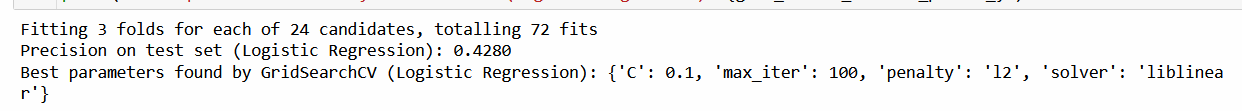

In [51]:
# Define the parameter grid for Logistic Regression
param_grid = {
    'penalty': ['l2'],  # Regularization term
    'C': [0.1],  # Inverse of regularization strength
    'solver': ['liblinear'],  # Solver for optimization
    'max_iter': [100]  # Maximum number of iterations
}

# Create the Logistic Regression model
lr_model = LogisticRegression()

# Define the custom precision scoring function
precision_scorer = make_scorer(precision_score)

# Initialize GridSearchCV
grid_search_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid, 
                              scoring=precision_scorer, cv=3, verbose=1, n_jobs=-1)

# Fit the grid search to the training data
grid_search_lr.fit(X_train, y_train)

# Get the best model from the grid search
best_model_lr = grid_search_lr.best_estimator_

# Make predictions on the train set
y_pred_proba_train_lr = best_model_lr.predict_proba(X_train)[:, 1]  # Get probabilities for class 1

# Apply custom threshold to convert probabilities into binary predictions
y_pred_train_lr_tuned = np.where(y_pred_proba_train_lr >= 0.34, 1, 0)

# Make predictions on the test set
y_pred_proba_test_lr = best_model_lr.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Apply custom threshold to convert probabilities into binary predictions
y_pred_test_lr_tuned = np.where(y_pred_proba_test_lr >= 0.34, 1, 0)

# Evaluate precision on the test set using the custom threshold
precision_test_lr = precision_score(y_test, y_pred_test_lr_tuned)
print(f"Precision on test set (Logistic Regression): {precision_test_lr:.4f}")

# Display the best parameters found by the grid search
print(f"Best parameters found by GridSearchCV (Logistic Regression): {grid_search_lr.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Precision on test set (Logistic Regression): 0.4280
Best parameters found by GridSearchCV (Logistic Regression): {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


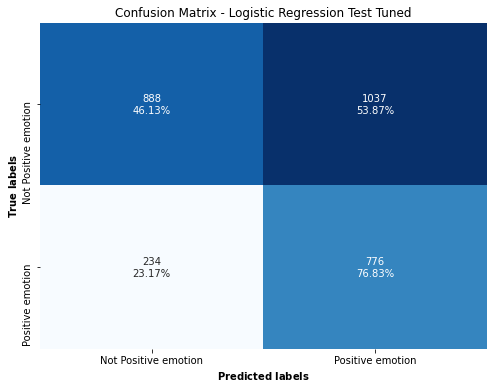

Weighted Precision: 0.67
Weighted Recall: 0.57
Weighted F1 Score: 0.57


In [52]:
plot_confusion_matrix_and_metrics(y_test, y_pred_test_lr_tuned, title='Confusion Matrix - Logistic Regression Test Tuned');

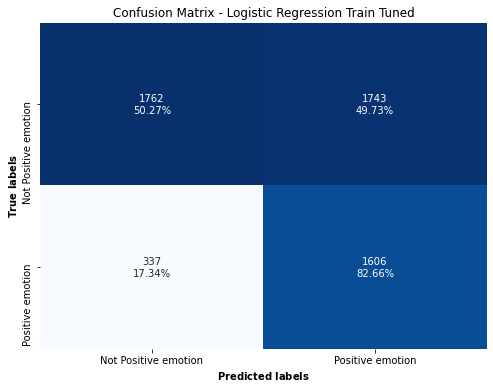

Weighted Precision: 0.71
Weighted Recall: 0.62
Weighted F1 Score: 0.62


In [53]:
plot_confusion_matrix_and_metrics(y_train, y_pred_train_lr_tuned, title='Confusion Matrix - Logistic Regression Train Tuned');

## 6.7 Choosing the model

### 6.7.1 Explanation of the model chosen

After considering the different models that were run, we believe that XGBoost is the most adequate for different reasons: it has one of the highest precision, and the less overfitting maintaining the same metrics.

### 6.7.2 Saving the model in a pickle

In [ ]:
with open('pickle_objects/model.pkl', 'wb') as file:
    pickle.dump(best_model_xgb_precision, file)

# 7. Conclusion

We have built the best model to detect tweets with positive sentiment, achieving 58% success by optimizing for precision. Our focus is to avoid mistakes when identifying a tweet as having a positive emotion. The reason for this is tied to our business case and the next steps of this project, which involve distinguishing the characteristics of technological products that evoke positive emotions in the public. If we fail to minimize false positives, this would negatively impact our future model aimed at identifying the features of a technological product that trigger positive emotions.

This model enables us to gain reasonable insights when extracting positive features from tweets. By focusing on precision, we ensure that the positive sentiment tweets we identify are highly likely to reflect genuine positivity, which is crucial for the reliability of subsequent analyses.

In the future, the company's intention is that once the positive tweets are extracted, a model will be built to determine the characteristics of technological products that lead to positive sentiment towards the product. This approach will provide deeper insights into what aspects of these products resonate positively with the audience, further enhancing our overall analysis.

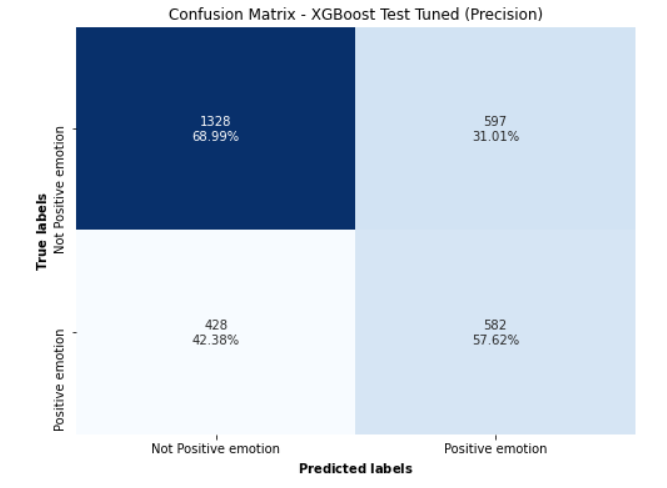